
Credit: https://github.com/luke4u/Time_Series_Forecasting/blob/main/Stock_price_prediction/Stock_price_prediction_LSTM.ipynb?fbclid=IwAR0tT9LIaM3BGtmu3kJkVIdjxNiBjLOwXl-b8V7m-xgjgK2B4hkCZjbOX-Q

In [54]:
!nvidia-smi

Fri Feb 11 01:35:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    68W / 149W |    245MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

The data is saved in .csv files. 2004-2019





# Download dataset

In [56]:
!wget https://github.com/kaopanboonyuen/Kao/raw/master/dataset/GOOG.csv

--2022-02-11 01:35:55--  https://github.com/kaopanboonyuen/Kao/raw/master/dataset/GOOG.csv
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kaopanboonyuen/Kao/master/dataset/GOOG.csv [following]
--2022-02-11 01:35:55--  https://raw.githubusercontent.com/kaopanboonyuen/Kao/master/dataset/GOOG.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 284248 (278K) [text/plain]
Saving to: ‘GOOG.csv.1’

GOOG.csv.1          100%[===================>] 277.59K  --.-KB/s    in 0.04s   

2022-02-11 01:35:55 (6.92 MB/s) - ‘GOOG.csv.1’ saved [284248/284248]



In [57]:
data = pd.read_csv('GOOG.csv', date_parser = True)
data.sample(5)

,Date,Open,High,Low,Close,Adj Close,Volume
2734,2015-06-30,526.020020,526.250000,520.500000,520.510010,520.510010,2217200
520,2006-09-12,191.781158,195.631729,191.721375,195.218277,195.218277,10925100
129,2005-02-23,96.289085,96.876884,93.977745,96.612869,96.612869,31288700
3199,2017-05-04,926.070007,935.929993,924.590027,931.659973,931.659973,1422100
3745,2019-07-08,1125.170044,1125.979980,1111.209961,1116.349976,1116.349976,1236400


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3809 entries, 0 to 3808
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3809 non-null   object 
 1   Open       3809 non-null   float64
 2   High       3809 non-null   float64
 3   Low        3809 non-null   float64
 4   Close      3809 non-null   float64
 5   Adj Close  3809 non-null   float64
 6   Volume     3809 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 208.4+ KB


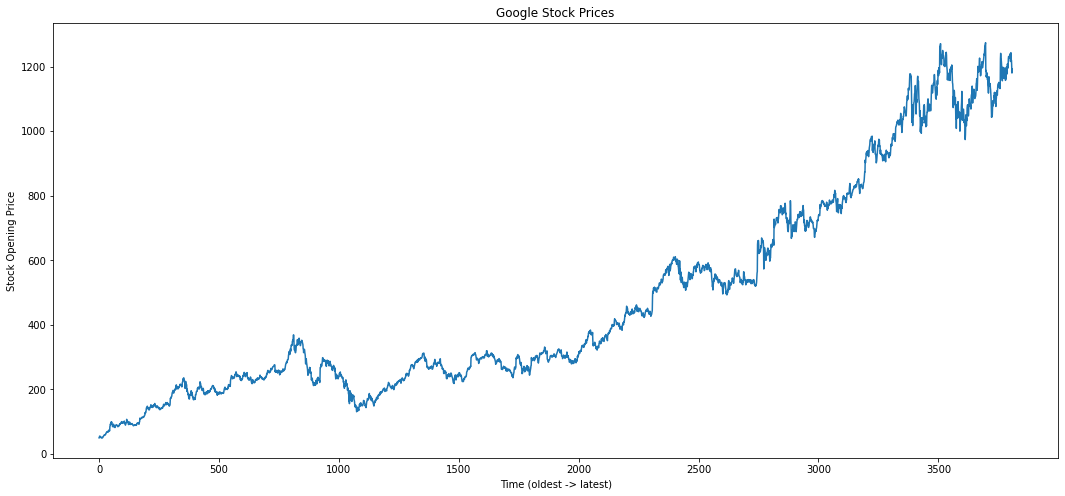

In [59]:
plt.figure(figsize=(18, 8))
plt.plot(data['Open'])
plt.title("Google Stock Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Opening Price")
plt.show()

# Data preparation

## Train/test split

In [60]:
data_training = data[data['Date']<'2019-01-01'].copy()
data_test = data[data['Date']>='2019-01-01'].copy()

In [61]:
data_training = data_training.drop(['Date', 'Adj Close'], axis = 1)

In [62]:
data_training.head()

,Open,High,Low,Close,Volume
0,49.813286,51.835709,47.800831,49.982655,44871300
1,50.316402,54.336334,50.062355,53.952770,22942800
2,55.168217,56.528118,54.321388,54.495735,18342800
3,55.412300,55.591629,51.591621,52.239193,15319700
4,52.284027,53.798351,51.746044,52.802086,9232100


The next step is to scale the stock prices between (0, 1) to avoid intensive computation. Common methods include Standardization and Normalization

## Normalize data

In [63]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)

In [64]:
scaler.inverse_transform(data_training)

array([[4.98132860e+01, 5.18357090e+01, 4.78008310e+01, 4.99826550e+01,
        4.48713000e+07],
       [5.03164020e+01, 5.43363340e+01, 5.00623550e+01, 5.39527700e+01,
        2.29428000e+07],
       [5.51682170e+01, 5.65281180e+01, 5.43213880e+01, 5.44957350e+01,
        1.83428000e+07],
       ...,
       [1.01715002e+03, 1.04389001e+03, 9.97000000e+02, 1.04388000e+03,
        2.10980000e+06],
       [1.04962000e+03, 1.05556006e+03, 1.03309998e+03, 1.03707996e+03,
        1.41480000e+06],
       [1.05095996e+03, 1.05269995e+03, 1.02359003e+03, 1.03560999e+03,
        1.49330000e+06]])

In [65]:
scale = 1/scaler.scale_
temp = (data_training * scale) + scaler.min_
temp

array([[ 3.63037884e-01,  1.11423900e+00, -3.97935959e-02,
         1.23502478e-01,  4.48634000e+07],
       [ 8.66153884e-01,  3.61486400e+00,  2.22173040e+00,
         4.09361748e+00,  2.29349000e+07],
       [ 5.71796888e+00,  5.80664800e+00,  6.48076340e+00,
         4.63658248e+00,  1.83349000e+07],
       ...,
       [ 9.67699776e+02,  9.93168545e+02,  9.49159375e+02,
         9.94020852e+02,  2.10190000e+06],
       [ 1.00016975e+03,  1.00483859e+03,  9.85259351e+02,
         9.87220803e+02,  1.40690000e+06],
       [ 1.00150971e+03,  1.00197848e+03,  9.75749402e+02,
         9.85750832e+02,  1.48540000e+06]])

create RNN with 60 timesteps, i.e. look 60 previous time steps

In [66]:
data_training[0:10]

array([[3.30294890e-04, 9.44785459e-04, 0.00000000e+00, 1.34908021e-04,
        5.43577404e-01],
       [7.42148227e-04, 2.98909923e-03, 1.88269054e-03, 3.39307537e-03,
        2.77885613e-01],
       [4.71386886e-03, 4.78092896e-03, 5.42828241e-03, 3.83867225e-03,
        2.22150736e-01],
       [4.91367646e-03, 4.01532941e-03, 3.15578542e-03, 1.98678849e-03,
        1.85522018e-01],
       [2.35285614e-03, 2.54928676e-03, 3.28434064e-03, 2.44873974e-03,
        1.11762967e-01],
       [2.34877785e-03, 2.52892558e-03, 3.60779701e-03, 3.22955376e-03,
        8.62763771e-02],
       [3.63326671e-03, 2.80177162e-03, 4.03492722e-03, 2.51005881e-03,
        7.55243925e-02],
       [2.48334262e-03, 1.52712947e-03, 2.50886935e-03, 8.17608079e-04,
        6.31682127e-02],
       [1.26817570e-03, 8.02253103e-04, 2.57107531e-03, 9.64778600e-04,
        5.97732318e-02],
       [1.43128522e-03, 5.00900100e-04, 1.53849690e-03, 9.81131336e-05,
        1.11151095e-01]])

A special data structure is needed to cover 60-time stamps, based on which RNN will predict the 61st price.

In [67]:
X_train = []
y_train = []

for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [68]:
X_train.shape

(3557, 60, 5)

# Building Model1: LSTM

In [69]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [70]:
tf.__version__

'2.7.0'

Fundamentally, we are building a NN regressor for continuous value prediction using LSTM. First, initialize the model.

In [71]:
modelLSTM = Sequential()

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(LSTM(units = 120, activation = 'relu'))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(units = 1))

In [72]:
modelLSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 60)            15840     
                                                                 
 dropout_8 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 60)            29040     
                                                                 
 dropout_9 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_10 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_7 (LSTM)               (None, 120)              

Callbacks
*   EarlyStoping: It will stop the traning if score of model didn't increase. This prevent model from overfitting. We are to set max in 10 epoches if it didn't increase then we will stop the training
*   ReduceLROnPlateau: Use for reduce the learning rate. In 3 steps the score didn't increase we will reduce the learning rate to improve the training
*   ModelCheckpoint: Use for save model only when the score increased




In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [74]:
#create callback
filepath = 'my_best_modelLSTM_yourself.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

For optimizer, we use Adam, a safe choice to start with. The loss function is the mean of squared errors between actual values and predictions.

In [75]:
modelLSTM.compile(optimizer='adam', loss = 'mean_squared_error')

RNN weights are updated every 32 stock prices with a batch size of 32.

In [76]:
# history = modelLSTM.fit(X_train, y_train, epochs=10, batch_size=32, callbacks=callbacks)

In [77]:
# download pre-trained weight
!wget https://storage.googleapis.com/kao-weights/my_best_modelLSTM.hdf5

--2022-02-11 01:35:56--  https://storage.googleapis.com/kao-weights/my_best_modelLSTM.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 142.250.157.128, 142.251.8.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2309856 (2.2M) [application/octet-stream]
Saving to: ‘my_best_modelLSTM.hdf5.1’

my_best_modelLSTM.h 100%[===================>]   2.20M  --.-KB/s    in 0.07s   

2022-02-11 01:35:57 (32.0 MB/s) - ‘my_best_modelLSTM.hdf5.1’ saved [2309856/2309856]



In [78]:
history= modelLSTM.load_weights('my_best_modelLSTM.hdf5')

# Testing

In [79]:
data = pd.read_csv('GOOG.csv', date_parser = True)
data_training = data[data['Date']<'2019-01-01'].copy()
data_test = data[data['Date']>='2019-01-01'].copy()

In [80]:
data_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
3617,2019-01-02,1016.570007,1052.319946,1015.710022,1045.849976,1045.849976,1532600
3618,2019-01-03,1041.000000,1056.979980,1014.070007,1016.059998,1016.059998,1841100
3619,2019-01-04,1032.589966,1070.839966,1027.417969,1070.709961,1070.709961,2093900
3620,2019-01-07,1071.500000,1074.000000,1054.760010,1068.390015,1068.390015,1981900
3621,2019-01-08,1076.109985,1084.560059,1060.530029,1076.280029,1076.280029,1764900


In [81]:
data_training.tail(60)

,Date,Open,High,Low,Close,Adj Close,Volume
3557,2018-10-04,1195.329956,1197.510010,1155.576050,1168.189941,1168.189941,2209500
3558,2018-10-05,1167.500000,1173.500000,1145.119995,1157.349976,1157.349976,1184300
3559,2018-10-08,1150.109985,1168.000000,1127.364014,1148.969971,1148.969971,1932400
3560,2018-10-09,1146.150024,1154.349976,1137.572021,1138.819946,1138.819946,1308700
3561,2018-10-10,1131.079956,1132.170044,1081.130005,1081.219971,1081.219971,2675700
3562,2018-10-11,1072.939941,1106.400024,1068.270020,1079.319946,1079.319946,2949000
3563,2018-10-12,1108.000000,1115.000000,1086.401978,1110.079956,1110.079956,2101300
3564,2018-10-15,1108.910034,1113.446045,1089.000000,1092.250000,1092.250000,1372400
3565,2018-10-16,1104.589966,1124.219971,1102.500000,1121.280029,1121.280029,1928500
3566,2018-10-17,1126.459961,1128.989990,1102.189941,1115.689941,1115.689941,1467200


## Prepare testing data

In [82]:
past_60_days = data_training.tail(60)

In [83]:
df = past_60_days.append(data_test, ignore_index = True)
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,1195.329956,1197.510010,1155.576050,1168.189941,2209500
1,1167.500000,1173.500000,1145.119995,1157.349976,1184300
2,1150.109985,1168.000000,1127.364014,1148.969971,1932400
3,1146.150024,1154.349976,1137.572021,1138.819946,1308700
4,1131.079956,1132.170044,1081.130005,1081.219971,2675700


In [84]:
inputs = scaler.transform(df)
inputs

array([[0.93805611, 0.93755773, 0.92220906, 0.91781776, 0.0266752 ],
       [0.91527437, 0.91792904, 0.91350452, 0.90892169, 0.01425359],
       [0.90103881, 0.91343268, 0.89872289, 0.90204445, 0.02331778],
       ...,
       [0.93940683, 0.93712442, 0.93529076, 0.9247443 , 0.01947328],
       [0.92550693, 0.93064972, 0.92791493, 0.9339358 , 0.01954719],
       [0.93524016, 0.94894575, 0.95017564, 0.95130949, 0.01227612]])

In [85]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [86]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((192, 60, 5), (192,))

## Model prediction

In [87]:
y_pred = modelLSTM.predict(X_test)

Don’t forget, what we have predicted is the scaled values, so we need to reverse the prediction.

In [88]:
scaler.scale_

array([8.18605127e-04, 8.17521128e-04, 8.32487534e-04, 8.20673293e-04,
       1.21162775e-08])

In [89]:
scale = 1/scaler.scale_[0]
scale

1221.590199

In [90]:
y_pred = y_pred*scale
y_test = y_test*scale

In [91]:
import math
from sklearn.metrics import mean_squared_error

def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print( 'MPAE =', MAPE(y_test, y_pred) )
print( 'RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

MPAE = 8.825133086067998
RMSE = 100.33976076346941


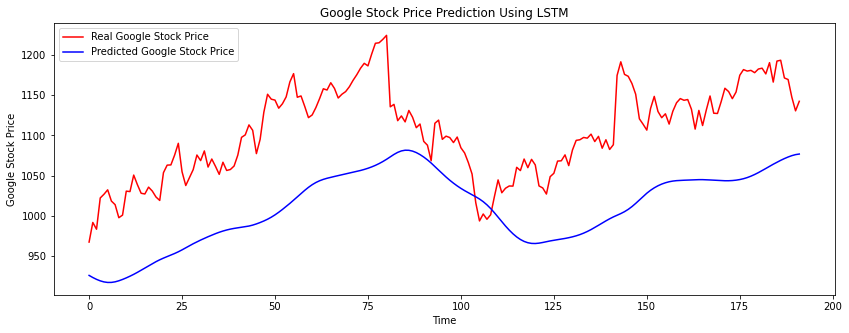

In [92]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Google Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction Using LSTM')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

# Building Model2: GRU

In [93]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout

In [94]:
# The GRU architecture
modelGRU = Sequential()

modelGRU.add(GRU(units = 50, activation = 'relu', return_sequences = True, input_shape=(X_train.shape[1],5)))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50, return_sequences=True))
modelGRU.add(Dropout(0.2))

modelGRU.add(GRU(units=50))
modelGRU.add(Dropout(0.2))

modelGRU.add(Dense(units=1))

In [95]:
modelGRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 60, 50)            8550      
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_13 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_6 (GRU)                 (None, 60, 50)            15300     
                                                                 
 dropout_14 (Dropout)        (None, 60, 50)            0         
                                                                 
 gru_7 (GRU)                 (None, 50)               

In [96]:
#create callback
filepath = 'my_best_modelGRU.hdf5'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=0, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(
    monitor='loss', 
    patience=3, 
    min_delta=0, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=0
)
callbacks = [checkpoint, earlystopping, reduce_lr]

In [97]:
modelGRU.compile(optimizer='sgd', loss='mean_squared_error')

In [98]:
# modelGRU.fit(X_train, y_train, epochs=10, batch_size=16, callbacks=callbacks)

In [99]:
# download pre-trained weight
!wget https://storage.googleapis.com/kao-weights/my_best_modelGRU.hdf5
history= modelGRU.load_weights('my_best_modelGRU.hdf5')

--2022-02-11 01:35:59--  https://storage.googleapis.com/kao-weights/my_best_modelGRU.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.97.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.97.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 257768 (252K) [application/octet-stream]
Saving to: ‘my_best_modelGRU.hdf5.1’

my_best_modelGRU.hd 100%[===================>] 251.73K  --.-KB/s    in 0.002s  

2022-02-11 01:35:59 (104 MB/s) - ‘my_best_modelGRU.hdf5.1’ saved [257768/257768]



In [100]:
y_pred = modelGRU.predict(X_test)

In [101]:
y_pred = y_pred*scale

In [102]:
import math
from sklearn.metrics import mean_squared_error
print( 'MPAE =', MAPE(y_test, y_pred) )
print( 'RMSE =', math.sqrt(mean_squared_error(y_test, y_pred)) )

MPAE = 5.861238189769883
RMSE = 38.516345483389244


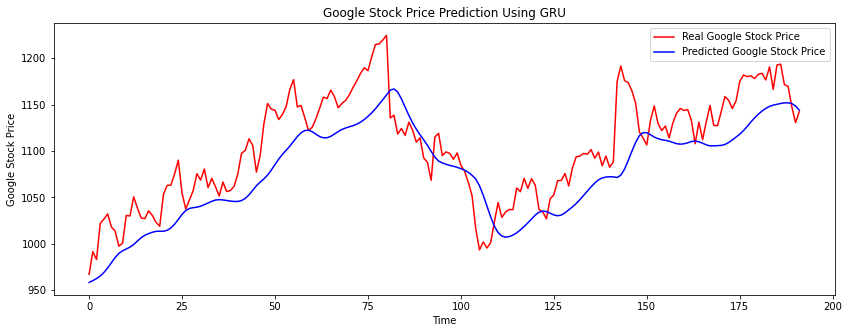

In [103]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Google Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction Using GRU')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()